# Crafting summary statistics


Many simulators produce outputs that are high-dimesional. For example, a simulator might generate a time series or an image. In a [previous tutorial](https://sbi-dev.github.io/sbi/tutorial/05_embedding_net/), we discussed how a neural networks can be used to learn summary statistics from such data. In this notebook, we will instead focus on hand-crafting summary statistics. We demonstrate that the choice of summary statistics can be crucial for the performance of the inference algorithm.


In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import torch

# sbi
import sbi.utils as utils
from sbi.analysis import pairplot
from sbi.inference import SNPE

In [3]:
# remove top and right axis from plots
mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.top"] = False

This notebook is not intended to provide a one-fits-all approach. In fact it argues against this: it argues for the user to carefully construct their summary statistics to (i) further help the user understand his observed data, (ii) help them understand exactly what they want the model to recover from the observation and (iii) help the inference framework itself.


# Example 1: The quadratic function


Assume we have a simulator that is given by a quadratic function:

$x(t) = a\cdot t^2 + b\cdot t + c + \epsilon$,

where $\epsilon$ is Gaussian observation noise and $\theta = \{a, b, c\}$ are the parameters. Given an observed quadratic function $x_o$, we would like to recover the posterior over parameters $a_o$, $b_o$ and $c_o$.


## 1.1 Prior over parameters


First we define a prior distribution over parameters $a$, $b$ and $c$. Here, we use a uniform prior for $a$, $b$ and $c$ to go from $-1$ to $1$.


In [10]:
prior_min = [-1, -1, -1]
prior_max = [1, 1, 1]
prior = utils.torchutils.BoxUniform(
    low=torch.as_tensor(prior_min), high=torch.as_tensor(prior_max)
)

## 1.2 Simulator


Defining some helper functions first:


In [14]:
def create_t_x(theta, seed=None):
    """Return an t, x array for plotting based on params"""
    if theta.ndim == 1:
        theta = theta[np.newaxis, :]

    rng = np.random.RandomState(seed) if seed is not None else np.random.RandomState()

    t = np.linspace(-1, 1, 200)
    ts = np.repeat(t[:, np.newaxis], theta.shape[0], axis=1)
    x = (
        theta[:, 0] * ts**2
        + theta[:, 1] * ts
        + theta[:, 2]
        + 0.01 * rng.randn(ts.shape[0], theta.shape[0])
    )
    return t, x


def eval(theta, t, seed=None):
    """Evaluate the quadratic function at `t`"""

    if theta.ndim == 1:
        theta = theta[np.newaxis, :]

    rng = np.random.RandomState(seed) if seed is not None else np.random.RandomState()

    return theta[:, 0] * t**2 + theta[:, 1] * t + theta[:, 2] + 0.01 * rng.randn(1)

In this example, we generate the observation $x_o$ from parameters $\theta_o=(a_o, b_o, c_o)=(0.3, -0.2, -0.1)$. The observation as follows.


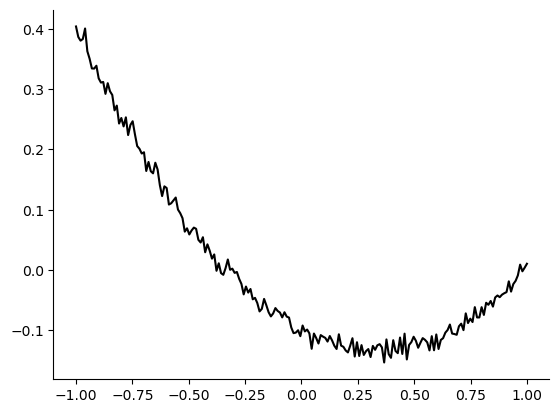

In [17]:
theta_o = np.array([0.3, -0.2, -0.1])
t, x = create_t_x(theta_o)
plt.plot(t, x, "k")

## 1.3 Summary statistics


We will compare two methods for defining summary statistics. One method uses three summary statistics which are function evaluations at three points in time. The other method uses a single summary statistic: the mean squared error between the observed and the simulated trace. In the second case, one then tries to obtain the posterior $p(\theta | 0)$, i.e. the error being zero. These two methods are implemented below:
<br>
$\textbf{get_3_values()}$ returns 3 function evaluations at $x=-0.5, x=0$ and $x=0.75$.
<br>
$\textbf{get_MSE()}$ returns the mean squared error between true and a quadratic function corresponding to a prior distributions sample.


In [21]:
def get_3_values(theta, seed=None):
    """
    Return 3 'x' values corresponding to t=-0.5,0,0.75 as summary statistic vector
    """
    return np.array(
        [
            eval(theta, -0.5, seed=seed),
            eval(theta, 0, seed=seed),
            eval(theta, 0.75, seed=seed),
        ]
    ).T

In [23]:
def get_MSE(theta, theta_o, seed=None):
    """
    Return the mean-squared error (MSE) i.e. Euclidean distance from the
    observation function
    """
    _, x = create_t_x(theta_o, seed=seed)  # truth
    _, x_ = create_t_x(theta, seed=seed)  # simulations
    return np.mean(np.square(x_ - x), axis=0, keepdims=True).T  # MSE

Let's try a couple of samples from our prior and see their summary statistics. Notice that these indeed change in small amounts every time you rerun it due to the noise, except if you set the seed.


## 1.4 Simulating data


Let us see various plots of prior samples and their summary statistics versus the truth, i.e. our artificial observation.


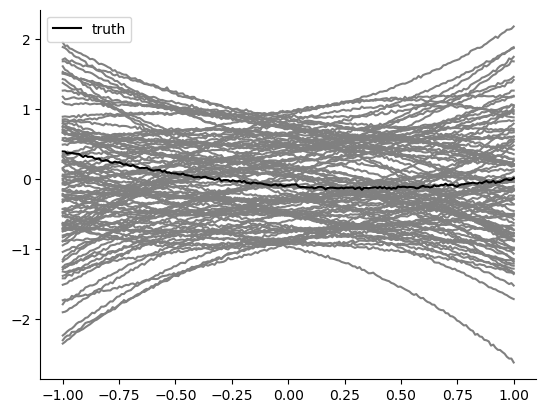

In [28]:
t, x_truth = create_t_x(theta_o)
plt.plot(t, x_truth, "k", zorder=1, label="truth")
n_samples = 100
theta = prior.sample((n_samples,))
t, x = create_t_x(theta.numpy())
plt.plot(t, x, "grey", zorder=0)
plt.legend()

In summary, we defined reasonable summary statistics and, a priori, there might be an apparent reason why one method would be better than another. When we do inference, we'd like our posterior to focus around parameter samples that have their simulated MSE very close to 0 (i.e. the truth MSE summary statistic) or their 3 extracted $(t, x)$ coordinates to be the truthful ones.


## 1.5 Inference


### 1.5.1 Using the MSE


Let's see if we can use the MSE to recover the true observation parameters $\theta_o=(a_0,b_0,c_0)$.


In [34]:
theta = prior.sample((1000,))
x = get_MSE(theta.numpy(), theta_o)

theta = torch.as_tensor(theta, dtype=torch.float32)
x = torch.as_tensor(x, dtype=torch.float32)

In [36]:
inference = SNPE(prior)
_ = inference.append_simulations(theta, x).train()
posterior = inference.build_posterior()

 Neural network successfully converged after 113 epochs.

Now that we've built the posterior as such, we can see how likely it finds certain parameters given that we tell it that we've observed a certain summary statistic (in this case the MSE). We can then sample from it.

In [38]:
x_o = torch.as_tensor(
    [
        [
            0.0,
        ]
    ]
)
theta_p = posterior.sample((10000,), x=x_o)

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

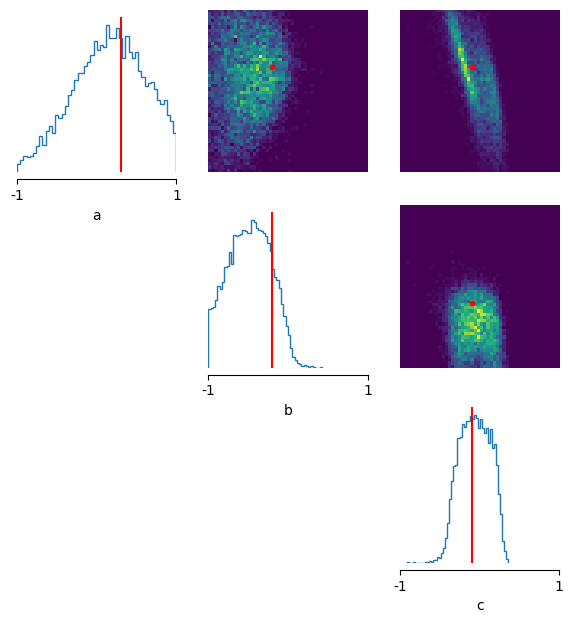

In [40]:
fig, axes = pairplot(
    theta_p,
    limits=list(zip(prior_min, prior_max)),
    ticks=list(zip(prior_min, prior_max)),
    figsize=(7, 7),
    labels=["a", "b", "c"],
    points_offdiag={"markersize": 6},
    points_colors="r",
    points=theta_o,
);

The posterior seems to pretty broad: i.e. it is not so certain about the 'true' parameters (here showcased in red).


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

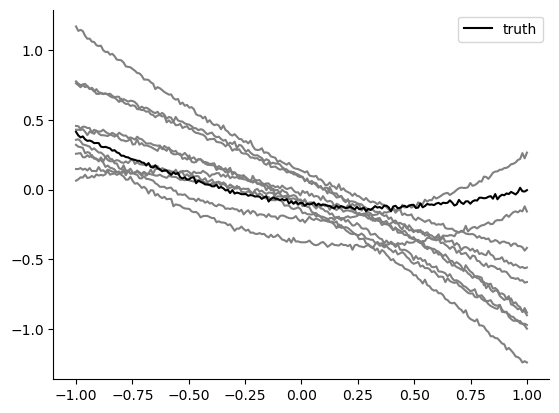

In [43]:
x_o_t, x_o_x = create_t_x(theta_o)
plt.plot(x_o_t, x_o_x, "k", zorder=1, label="truth")

theta_p = posterior.sample((10,), x=x_o)
x_t, x_x = create_t_x(theta_p.numpy())
plt.plot(x_t, x_x, "grey", zorder=0)
plt.legend()

The functions are a bit closer to the observation than prior samples, but many posterior samples generate activity that is very far off from the observation. We would expect `sbi` do better on such a simple example. So what's going on? Do we need more simulations? Feel free to try, but below we will show that one can use the same number of simulation samples with different summary statistics and do much better.


### 1.5.2 Using 3 coordinates as summary statistics


In [47]:
x = get_3_values(theta.numpy())
x = torch.as_tensor(x, dtype=torch.float32)

In [66]:
inference = SNPE(prior)

_ = inference.append_simulations(theta, x).train()
posterior = inference.build_posterior()

 Neural network successfully converged after 362 epochs.

The observation is now given by the values of the observed trace at three different coordinates:


In [69]:
x_o = torch.as_tensor(get_3_values(theta_o), dtype=float)

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

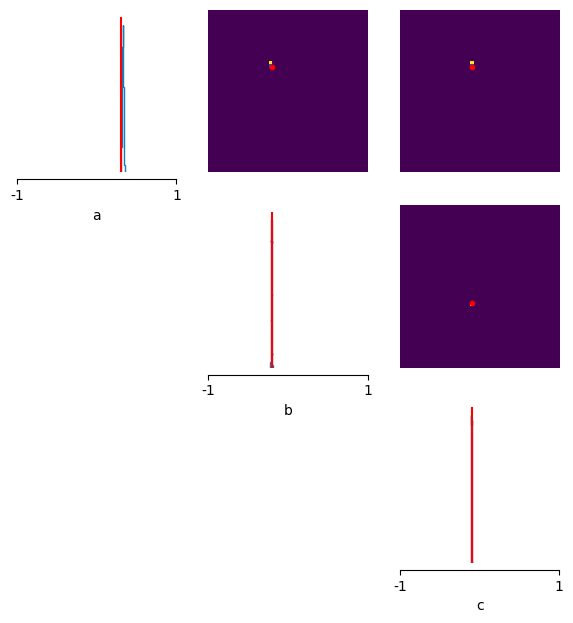

In [71]:
theta_p = posterior.sample((10000,), x=x_o)

fig, axes = pairplot(
    theta_p,
    limits=list(zip(prior_min, prior_max)),
    ticks=list(zip(prior_min, prior_max)),
    figsize=(7, 7),
    labels=["a", "b", "c"],
    points_offdiag={"markersize": 6},
    points_colors="r",
    points=theta_o,
);

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

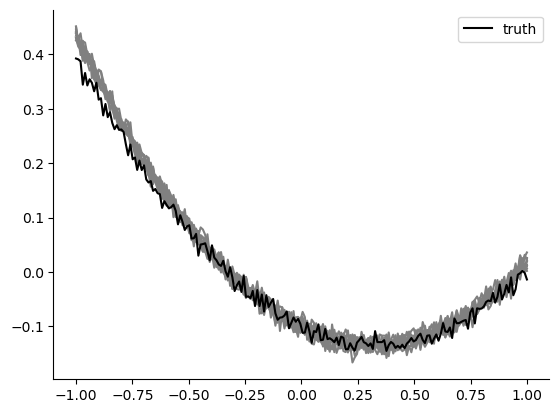

In [73]:
x_o_t, x_o_x = create_t_x(theta_o)
plt.plot(x_o_t, x_o_x, "k", zorder=1, label="truth")
theta_p = posterior.sample((100,), x=x_o)
ind_10_highest = np.argsort(np.array(posterior.log_prob(theta=theta_p, x=x_o)))[-10:]
theta_p_considered = theta_p[ind_10_highest, :]
x_t, x_x = create_t_x(theta_p_considered.numpy())
plt.plot(x_t, x_x, "grey", zorder=0)
plt.legend()

Ok this definitely seems to work! The posterior correctly focuses on the true parameters with greater confidence. You can experiment yourself how this improves further with more training samples or you could try to see how many you'd exactly need to keep having a satisfyingly looking posterior and high posterior sample simulations.


So, what's up with the MSE? Why does it not seem so informative to constrain the posterior? In 1.6, we'll see both the power and pitfalls of summary statistics.


## 1.6 Prior simulations' summary statistics vs observed summary statistics


Let's try to understand this...Let's look at a histogram of the four summary statistics we've experimented with, and see how they compare to our observed truth summary statistic vector:


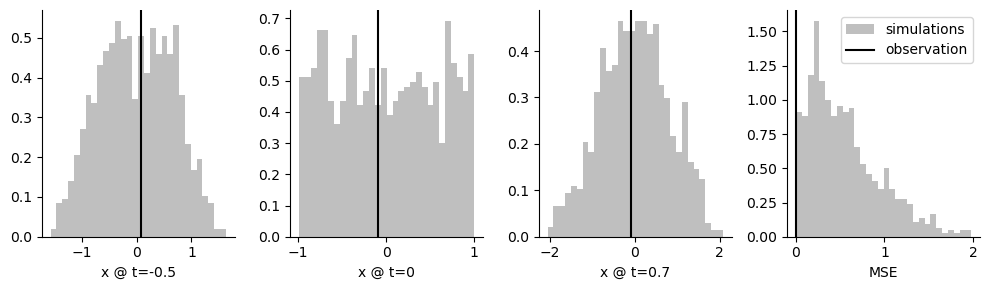

In [79]:
stats = np.concatenate(
    (get_3_values(theta.numpy()), get_MSE(theta.numpy(), theta_o)), axis=1
)
x_o = np.concatenate((get_3_values(theta_o), np.asarray([[0.0]])), axis=1)

features = ["x @ t=-0.5", "x @ t=0", "x @ t=0.7", "MSE"]
fig, axes = plt.subplots(1, 4, figsize=(10, 3))
xlabelfontsize = 10
for i, ax in enumerate(axes.reshape(-1)):
    ax.hist(
        stats[:, i],
        color=["grey"],
        alpha=0.5,
        bins=30,
        density=True,
        histtype="stepfilled",
        label=["simulations"],
    )
    ax.axvline(x_o[:, i], label="observation", color='k')
    ax.set_xlabel(features[i], fontsize=xlabelfontsize)
    if i == 3:
        ax.legend()
plt.tight_layout()

We see that for the coordinates (three plots on the left), simulations cover the observation. That is: it covers it from the left and right side in each case. For the MSE, simulations never truly reach the observation $0.0$.

For the trained neural network, it is strongly preferable if the simulations cover the observation. In that case, the neural network can **interpolate** between simulated data. Contrary to that, for the MSE, the neural network has to **extrapolate**: it never observes a simulation that is to the left of the observation and has to extrapolate to the region of MSE=$0.0$. This seems like a technical point but, as we saw above, it makes a huge difference in performance.


## 1.7 Explicit recommendations

We give some explicit recommendation when using summary statistics

- Visualize the histogram of each summary statistic and plot the value of the observation. If, for some summary statistics, the observation is not covered (or is at the very border, e.g. the MSE above), the trained neural network will struggle.

- Do not use an "error" as summary statistic. This is common in optimization (e.g. genetic algorithms), but it often leads to trouble in `sbi` due to the reason above.

- Only use summary statistics that are necessary. The less summary statistics you use, the less can go wrong with them. Of course, you have to ensure that the summary statistics describe the raw data sufficiently well.
